In [374]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [375]:
!wget -P . https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz

--2025-06-13 17:59:44--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4006:820::201b, 2607:f8b0:4006:821::201b, 2607:f8b0:4006:806::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4006:820::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘./mnist.npz.1’

mnist.npz.1         100%[===================>]  10.96M  25.8MB/s    in 0.4s    

2025-06-13 17:59:45 (25.8 MB/s) - ‘./mnist.npz.1’ saved [11490434/11490434]



In [1382]:
file_path = "mnist.npz"

try:
    # Open the .npz file
    with np.load(file_path, allow_pickle=True) as data:
        # Split training data: first 50000 for training, last 10000 for validation
        x_train = data['x_train'][:50000]  # First 50000 training images
        x_dev = data['x_train'][50000:]    # Last 10000 as validation images
        y_train = np.eye(10)[data['y_train'][:50000]]  # First 50000 training labels
        y_dev = np.eye(10)[data['y_train'][50000:]]    # Last 10000 as validation labels
        x_test = data['x_test']            # Test images
        y_test = np.eye(10)[data['y_test']]            # Test labels

        print("MNIST data loaded successfully!")
        print(f"Training images shape: {x_train.shape}")
        print(f"Training labels shape: {y_train.shape}")
        print(f"Validation images shape: {x_dev.shape}")
        print(f"Validation labels shape: {y_dev.shape}")
        print(f"Test images shape: {x_test.shape}")
        print(f"Test labels shape: {y_test.shape}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")

MNIST data loaded successfully!
Training images shape: (50000, 28, 28)
Training labels shape: (50000, 10)
Validation images shape: (10000, 28, 28)
Validation labels shape: (10000, 10)
Test images shape: (10000, 28, 28)
Test labels shape: (10000, 10)


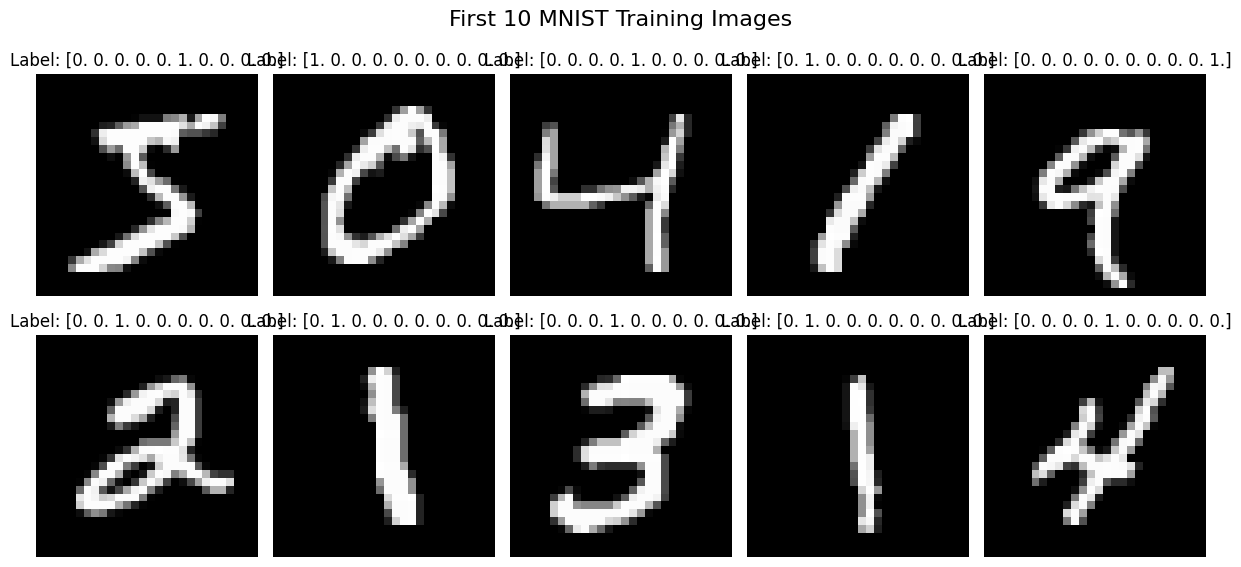

In [1383]:
number_of_images = 10

# Calculate subplot layout dynamically
cols = 5  # Number of columns
rows = (number_of_images + cols - 1) // cols  # Calculate rows needed

# Visualize the first number_of_images training images
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
fig.suptitle(f'First {number_of_images} MNIST Training Images', fontsize=16)

# Handle case where we have only one row
if rows == 1:
    axes = axes.reshape(1, -1)

for i in range(number_of_images):
    row = i // cols
    col = i % cols
    
    # Display the image
    axes[row, col].imshow(x_train[i], cmap='gray')
    axes[row, col].set_title(f'Label: {y_train[i]}')
    axes[row, col].axis('off')  # Remove axis ticks

# Hide any unused subplots
for i in range(number_of_images, rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [1384]:
class Tensor:
    def __init__(self, data, _children=(), _op=''):
        self.data = np.array(data)  # Convert data to numpy array
        self.dim = np.shape(self.data) #store the dimensions
        self.grad = np.zeros_like(self.data)  # Initialize gradient with zeros
        self._backward = lambda: None #store the backward function
        self.children = set(_children) #store the set of children
        self.op = _op #store the operation

    def __repr__(self):
        return f"Tensor(dim={self.dim}, data={repr(self.data)})"
    
    def __add__(self, other):
        out = Tensor(self.data + other.data, (self, other), '+')
        def _backward():
            if len(out.grad.shape) > len(self.grad.shape):
                shape = (1, ) * (len(out.grad.shape)- len(self.grad.shape)) + self.grad.shape
            else:
                shape = self.grad.shape
            # Sum out.grad to the shape of self.grad to handle broadcasting
            self.grad += np.sum(out.grad, axis=tuple(d for d, s in enumerate(shape) if s == 1), keepdims=len(out.grad.shape) == len(self.grad.shape))
            
            if len(out.grad.shape) > len(other.grad.shape):
                shape = (1, ) * (len(out.grad.shape)- len(other.grad.shape)) + other.grad.shape
            else:
                shape = other.grad.shape
            # Sum out.grad to the shape of other.grad to handle broadcasting
            other.grad += np.sum(out.grad, axis=tuple(d for d, s in enumerate(shape) if s == 1), keepdims=len(out.grad.shape) == len(other.grad.shape))
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Tensor(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out  # Return the tensor with the backward function attached
    
    def __truediv__(self, other):
        out = Tensor(self.data / other.data, (self, other), '/')
        def _backward():
            self.grad += 1 / other.data * out.grad
            other.grad -= self.data / np.power(other.data, 2) * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        out = Tensor(self.data + other.data, (self, other), '-')
        def _backward():
            if len(out.grad.shape) > len(self.grad.shape):
                shape = (1, ) * (len(out.grad.shape)- len(self.grad.shape)) + self.grad.shape
            else:
                shape = self.grad.shape
            # Sum out.grad to the shape of self.grad to handle broadcasting
            self.grad += np.sum(out.grad, axis=tuple(d for d, s in enumerate(shape) if s == 1), keepdims=len(out.grad.shape) == len(self.grad.shape))
            
            if len(out.grad.shape) > len(other.grad.shape):
                shape = (1, ) * (len(out.grad.shape)- len(other.grad.shape)) + other.grad.shape
            else:
                shape = other.grad.shape
            # Sum out.grad to the shape of other.grad to handle broadcasting
            other.grad -= np.sum(out.grad, axis=tuple(d for d, s in enumerate(shape) if s == 1), keepdims=len(out.grad.shape) == len(other.grad.shape))
        out._backward = _backward
        return out
    
    def __matmul__(self, other):
        out = Tensor(self.data @ other.data, (self, other), '@')
        def _backward():
            # For C = A @ B:
            # dC/dA = dC @ B.T
            # dC/dB = A.T @ dC
            self.grad += out.grad @ other.data.T
            other.grad += self.data.T @ out.grad
        out._backward = _backward
        return out  # Return the tensor with the backward function attached
    def tanh(self):
        out = Tensor(np.tanh(self.data), (self,), 'tanh')
        def _backward():
            self.grad += (1 - np.power(out.data, 2)) * out.grad
        out._backward = _backward
        return out
    
    def pow(self, power = 1):
        out = Tensor(np.power(self.data, power), (self,), '**')
        def _backward():
            self.grad += power * np.power(self.data, power-1) * out.grad
        out._backward = _backward
        return out
    
    def mean(self, axis=None, keepdims=False):
        out = Tensor(np.mean(self.data, axis=axis, keepdims=keepdims), (self,), 'mean')
        def _backward():
            # Create a gradient of the correct shape and distribute the incoming gradient
            self.grad += out.grad * np.ones_like(self.data) / self.data.size[axis]
        out._backward = _backward
        return out
    def mean(self, axis=None, keepdims=False):
        """
        Computes the mean of the tensor's data along the specified axis.
        """
        # Forward pass
        out = Tensor(np.mean(self.data, axis=axis, keepdims=keepdims), (self,), 'mean')

        def _backward():
            # Determine the number of elements that were averaged
            if axis is None:
                num_elements = self.data.size
            else:
                num_elements = self.data.shape[axis]
            self.grad += out.grad * np.ones_like(self.data) / num_elements
            
        out._backward = _backward
        return out
    def softmax(self, axis = 1):
        exps = np.exp(self.data - np.max(self.data, axis=axis, keepdims=True)) # a trick for numerical stability
        return Tensor(exps / np.sum(exps, axis=axis, keepdims=True), _children=(self,), _op='softmax')

    def cross_entropy(self, y_true):
        # Softmax for numerical stability
        exp_x = np.exp(self.data - np.max(self.data, axis=-1, keepdims=True))
        softmax_output = exp_x / np.sum(exp_x, axis=-1, keepdims=True)

        # Cross-entropy loss calculation
        loss = -np.sum(y_true.data * np.log(softmax_output + 1e-9))/ y_true.data.shape[0] # Add a small epsilon for numerical stability
        
        out = Tensor(loss, (self, ),'cross_entropy')
        
        def _backward():
            # Gradient of cross-entropy with softmax
            grad = softmax_output - y_true.data
            self.grad += out.grad.data * grad / y_true.data.shape[0]

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = np.ones_like(self.data)
        for node in reversed(topo):
            node._backward()
    
    

In [1396]:
#initialize the parameters
batch_size = 30
max_steps = 10000
n_hidden = 100
n_input = 28*28
n_output = 10
learning_rate = 0.01
loss_history = []

#initialize the weights and biases
w1 = Tensor(np.random.randn(n_input, n_hidden) * (1/np.sqrt(n_input)))
b1 = Tensor(np.zeros(n_hidden))
w2 = Tensor(np.random.randn(n_hidden, n_output)* (1/np.sqrt(n_hidden)))
b2 = Tensor(np.zeros(n_output))
print(w1.data.shape)
print(b1.data.shape)
print(w2.data.shape)
print(b2.data.shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [1395]:
#create a batch of data
batch_idx = np.random.randint(0, x_train.shape[0], batch_size)
x_batch = Tensor(x_train[batch_idx].reshape(-1, 28*28).astype(np.float64)/255)
y_batch = Tensor(y_train[batch_idx].astype(np.float64))

#forward pass
h1 = x_batch @ w1 + b1
h1t = h1.tanh()
h2 = h1t @ w2 + b2
loss = h2.cross_entropy(y_batch.data)

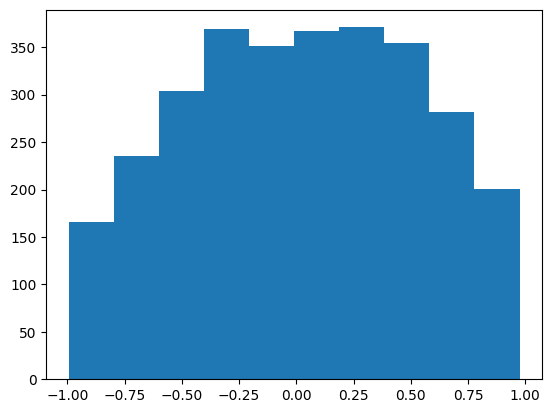

In [1393]:
plt.hist(h1t.data.reshape(-1).tolist())
plt.show()


In [1406]:
for i in range(max_steps*10):
    #create a batch of data
    batch_idx = np.random.randint(0, x_train.shape[0], batch_size)
    x_batch = Tensor(x_train[batch_idx].reshape(-1, 28*28).astype(np.float64)/255)
    y_batch = Tensor(y_train[batch_idx].astype(np.float64))

    #forward passx
    h1 = x_batch @ w1 + b1
    h1t = h1.tanh()
    h2 = h1t @ w2 + b2
    loss = h2.cross_entropy(y_batch.data)

    #backward pass
    w1.grad.fill(0)
    b1.grad.fill(0)
    w2.grad.fill(0)
    b2.grad.fill(0)
    loss.backward()

    #add the loss to the loss history
    loss_history.append(loss.data.mean())

    #update the weights and biases
    w1.data -= w1.grad * learning_rate
    b1.data -= b1.grad * learning_rate
    w2.data -= w2.grad * learning_rate
    b2.data -= b2.grad * learning_rate
    if i % 100 == 0:
        print(f"Step {i} Loss: {loss.data.mean()}")


Step 0 Loss: 0.050862411963647824
Step 100 Loss: 0.05273634428127014
Step 200 Loss: 0.06137793707286975
Step 300 Loss: 0.06928682934316362
Step 400 Loss: 0.0575333173096123
Step 500 Loss: 0.04934140144013709
Step 600 Loss: 0.055824758658727915
Step 700 Loss: 0.055829655034797414
Step 800 Loss: 0.04715457842150995
Step 900 Loss: 0.05877641465713699
Step 1000 Loss: 0.043289744324809934
Step 1100 Loss: 0.0789891659584719
Step 1200 Loss: 0.05312066468904804
Step 1300 Loss: 0.04733354643559215
Step 1400 Loss: 0.06268800405985153
Step 1500 Loss: 0.06355426638547593
Step 1600 Loss: 0.0473552420495636
Step 1700 Loss: 0.05517175959636039
Step 1800 Loss: 0.0683552700678349
Step 1900 Loss: 0.050104571249829546
Step 2000 Loss: 0.048843633639476455
Step 2100 Loss: 0.06020120129118173
Step 2200 Loss: 0.05637485646280583
Step 2300 Loss: 0.050364262219164166
Step 2400 Loss: 0.0565248858191948
Step 2500 Loss: 0.06062169116549514
Step 2600 Loss: 0.05933029885178703
Step 2700 Loss: 0.04616288788509094
St

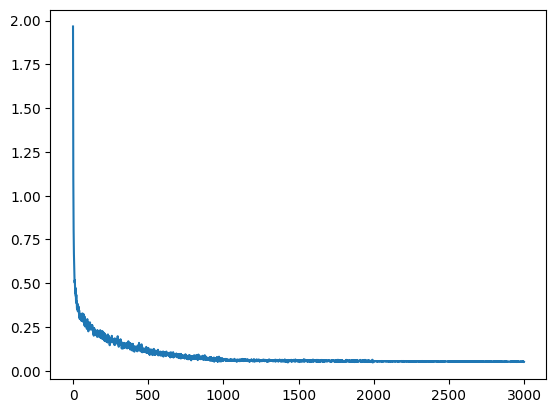

In [1407]:
loss_array = np.array(loss_history)

averaging_step = 100

# Trim the array so its length is a multiple of the step size
end_index = len(loss_array) - (len(loss_array) % averaging_step)
trimmed_array = loss_array[:end_index]

# Reshape the 1D array into a 2D array (e.g., 2000 -> 20x100) and take the mean of each row
averaged_losses = trimmed_array.reshape(-1, averaging_step).mean(axis=1)

plt.plot(averaged_losses)
plt.show()

In [1405]:
batch_size = 1000
learning_rate = 0.0005

In [1408]:
x_batch = Tensor(x_train.reshape(-1, 28*28).astype(np.float64))
y_batch = Tensor(y_train.astype(np.float64))

h1 = x_batch @ w1 + b1
h1t = h1.tanh()
h2 = h1t @ w2 + b2
loss = h2.cross_entropy(y_batch.data)

predicted_labels = np.argmax(h2.data, axis=1)
correct_predictions = (predicted_labels == np.argmax(y_batch.data, axis=1))
print("Train accuracy: ", np.mean(correct_predictions) * 100)
print("Train loss: ", loss.data)

x_batch = Tensor(x_dev.reshape(-1, 28*28).astype(np.float64))
y_batch = Tensor(y_dev.astype(np.float64))

h1 = x_batch @ w1 + b1
h1t = h1.tanh()
h2 = h1t @ w2 + b2
loss = h2.cross_entropy(y_batch.data)

predicted_labels = np.argmax(h2.data, axis=1)
correct_predictions = (predicted_labels == np.argmax(y_batch.data, axis=1))
print("Val accuracy: ", np.mean(correct_predictions) * 100)
print("Val loss: ", loss.data)


Train accuracy:  97.226
Train loss:  0.08422401636106068
Val accuracy:  96.17999999999999
Val loss:  0.15407852788644838


Predicted:  7
Actual:  7


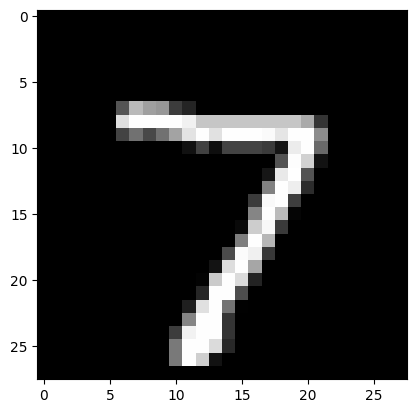

Predicted:  2
Actual:  2


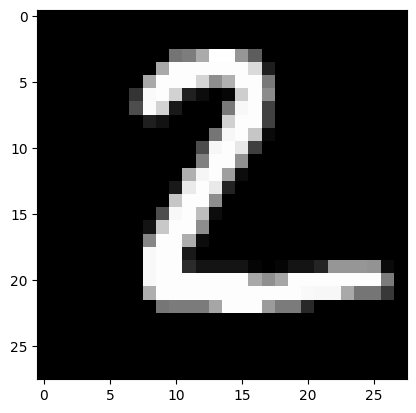

Predicted:  1
Actual:  1


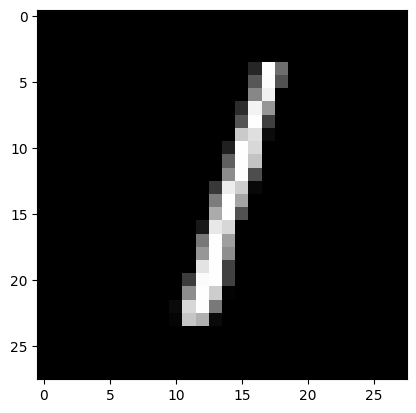

Predicted:  0
Actual:  0


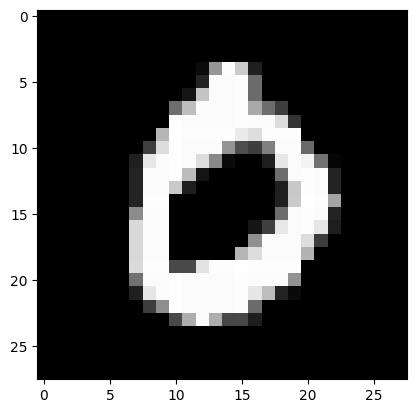

Predicted:  4
Actual:  4


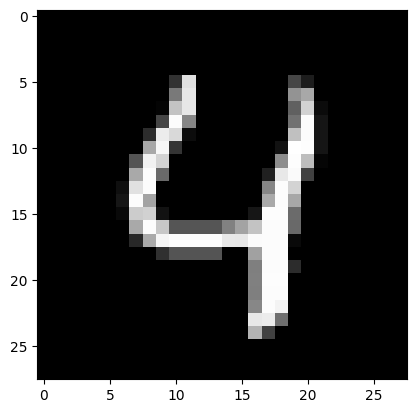

Predicted:  1
Actual:  1


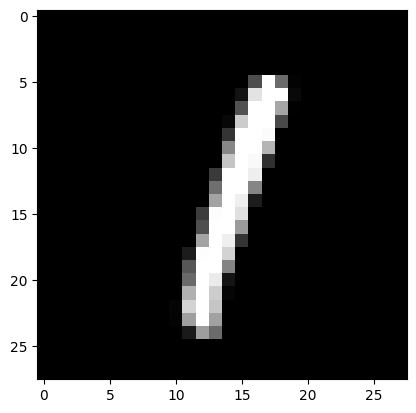

Predicted:  4
Actual:  4


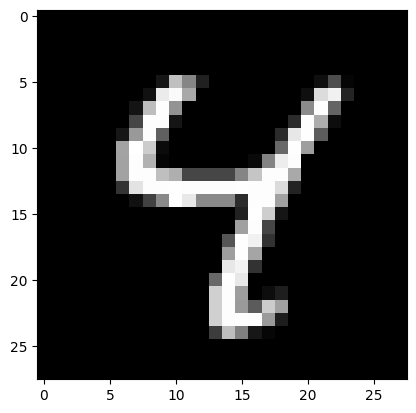

Predicted:  9
Actual:  9


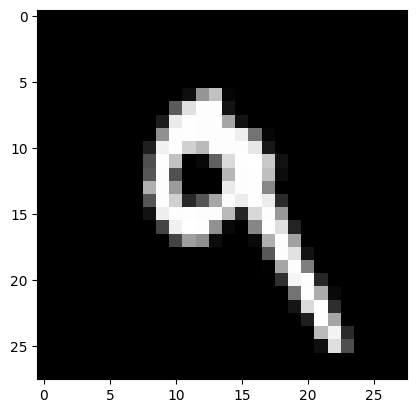

Predicted:  6
Actual:  5


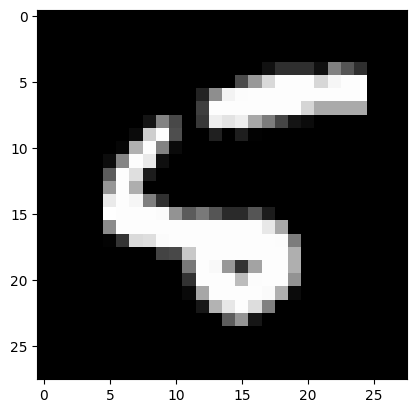

Predicted:  9
Actual:  9


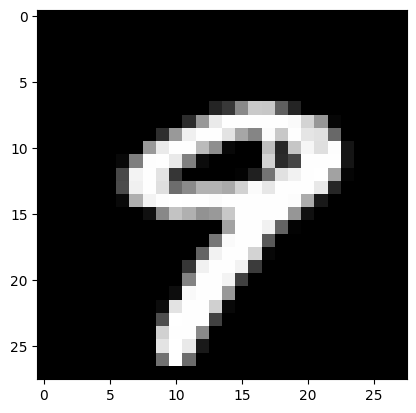

In [1425]:
for i in range(10):
    x_batch = Tensor(x_test[i].reshape(-1, 28*28).astype(np.float64)/255)
    y_batch = Tensor(y_test[i].reshape(-1, 10).astype(np.float64))

    h1 = x_batch @ w1 + b1
    h1t = h1.tanh()
    h2 = h1t @ w2 + b2
    out = h2.softmax()

    print("Predicted: ", np.argmax(out.data))
    print("Actual: ", np.argmax(y_batch.data))
    plt.imshow(x_batch.data.reshape(28, 28), cmap='gray')
    plt.show()